**Pelatihan Model**

In [ ]:
# Import libraries yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

In [ ]:
# Fungsi untuk mendapatkan label dari nama file
def get_label_from_filename(file_path):
    if 'rifampisin' in file_path.lower():
        return 0
    elif 'digoxin' in file_path.lower():
        return 1
    elif 'ctm' in file_path.lower():
        return 2
    elif 'simvastatin' in file_path.lower():
        return 3
    elif 'diclofenac_sodium' in file_path.lower():
        return 4
    else:
        raise ValueError(f"Unknown pollutant in file: {file_path}")

# Fungsi untuk memuat dan pra-proses data
def load_and_preprocess_data(file_path, selected_wavelengths):
    df = pd.read_excel(file_path)

    # Mengambil kolom panjang gelombang
    wavelengths = df['Wavelength'].values

    # Memilih indeks kolom berdasarkan panjang gelombang yang dipilih
    selected_indices = [np.argmin(np.abs(wavelengths - w)) for w in selected_wavelengths]

    # Memilih data spektrum (pastikan kolom yang diambil benar)
    X = df.iloc[:, 1:].values.T
    X = X[:, selected_indices]

    # Membuat label
    y = np.full(X.shape[0], get_label_from_filename(file_path))

    return X, y

In [ ]:
# Memuat data untuk berbagai polutan obat
file_paths = [
    '/content/spectrum_rifampisin.xlsx',
    '/content/spectrum_digoxin.xlsx',
    '/content/spectrum_ctm.xlsx',
    '/content/spectrum_simvastatin.xlsx',
    '/content/spectrum_diclofenac_sodium.xlsx'
]

In [ ]:
# Tentukan panjang gelombang yang ingin digunakan
selected_wavelengths = [400, 470, 511, 530, 611, 670]

X_list = []
y_list = []

for path in file_paths:
    X_temp, y_temp = load_and_preprocess_data(path, selected_wavelengths)
    X_list.append(X_temp)
    y_list.append(y_temp)

In [ ]:
# Menggabungkan semua data
X = np.vstack(X_list)
y = np.hstack(y_list)
print("Shape of combined X:", X.shape)
print("Shape of combined y:", y.shape)

Shape of combined X: (5000, 6)
Shape of combined y: (5000,)


In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Melakukan standardisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# One-hot encoding untuk label
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
# Membuat model JST
model = Sequential([
    Dense(12, activation='relu', input_shape=(len(selected_wavelengths),)),
    Dense(5, activation='softmax')  # 5 output neurons for 5 classes
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dense_1 (Dense)             (None, 5)                 65        
                                                                 
Total params: 149 (596.00 Byte)
Trainable params: 149 (596.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
100/100 [==============================] - 2s 7ms/step - loss: 1.4399 - accuracy: 0.3869 - val_loss: 1.1061 - val_accuracy: 0.7625
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.8491 - accuracy: 0.8544 - val_loss: 0.6149 - val_accuracy: 0.9600
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.4655 - accuracy: 0.9803 - val_loss: 0.3408 - val_accuracy: 0.9862
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2703 - accuracy: 0.9894 - val_loss: 0.2087 - val_accuracy: 0.9862
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.9900 - val_loss: 0.1428 - val_accuracy: 0.9825
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1258 - accuracy: 0.9891 - val_loss: 0.1064 - val_accuracy: 0.9825
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9894 - val_loss: 0.0846 - val_accuracy: 0.9825

In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9960
Test accuracy: 0.9960


32/32 [==============================] - 0s 2ms/step


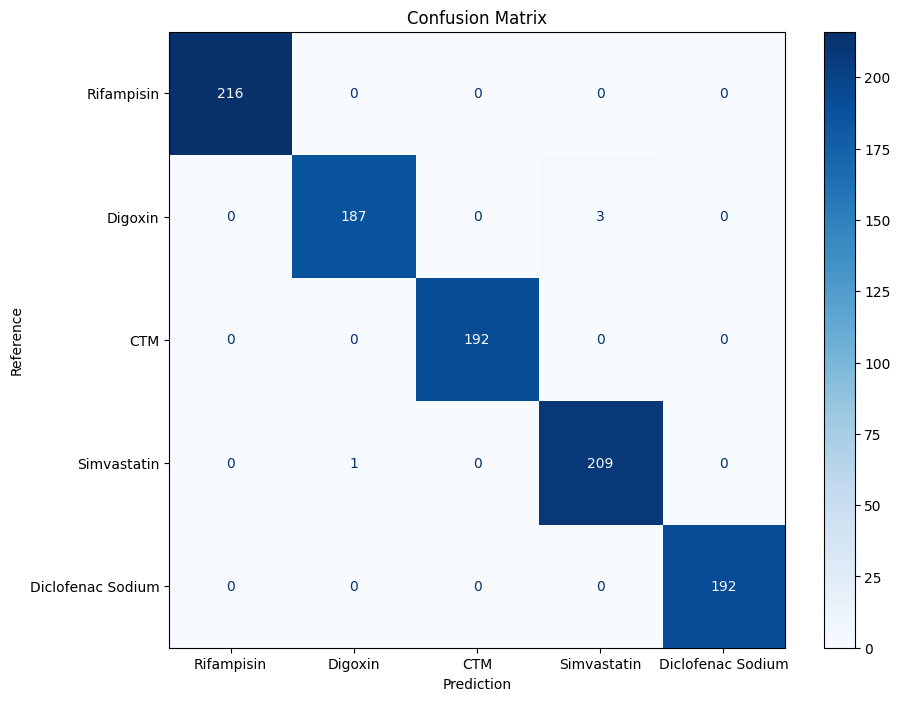

In [ ]:
# Membuat prediksi
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

class_names = ['Rifampisin', 'Digoxin', 'CTM', 'Simvastatin', 'Diclofenac Sodium']
cm = confusion_matrix(y_test_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Reference')
plt.show()

In [ ]:
# Menghitung dan menampilkan TN, TP, FN, FP untuk setiap kelas
n_classes = len(class_names)
for i in range(n_classes):
    tn = cm[np.arange(n_classes) != i, :][:, np.arange(n_classes) != i].sum()
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp

    print(f"\nMetrics for {class_names[i]}:")
    print(f"True Negatives (TN): {tn}")
    print(f"True Positives (TP): {tp}")
    print(f"False Negatives (FN): {fn}")
    print(f"False Positives (FP): {fp}")


Metrics for Rifampisin:
True Negatives (TN): 784
True Positives (TP): 216
False Negatives (FN): 0
False Positives (FP): 0

Metrics for Digoxin:
True Negatives (TN): 809
True Positives (TP): 187
False Negatives (FN): 3
False Positives (FP): 1

Metrics for CTM:
True Negatives (TN): 808
True Positives (TP): 192
False Negatives (FN): 0
False Positives (FP): 0

Metrics for Simvastatin:
True Negatives (TN): 787
True Positives (TP): 209
False Negatives (FN): 1
False Positives (FP): 3

Metrics for Diclofenac Sodium:
True Negatives (TN): 808
True Positives (TP): 192
False Negatives (FN): 0
False Positives (FP): 0


In [ ]:
# Menampilkan classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

Classification Report:
                   precision    recall  f1-score   support

       Rifampisin       1.00      1.00      1.00       216
          Digoxin       0.99      0.98      0.99       190
              CTM       1.00      1.00      1.00       192
      Simvastatin       0.99      1.00      0.99       210
Diclofenac Sodium       1.00      1.00      1.00       192

         accuracy                           1.00      1000
        macro avg       1.00      1.00      1.00      1000
     weighted avg       1.00      1.00      1.00      1000



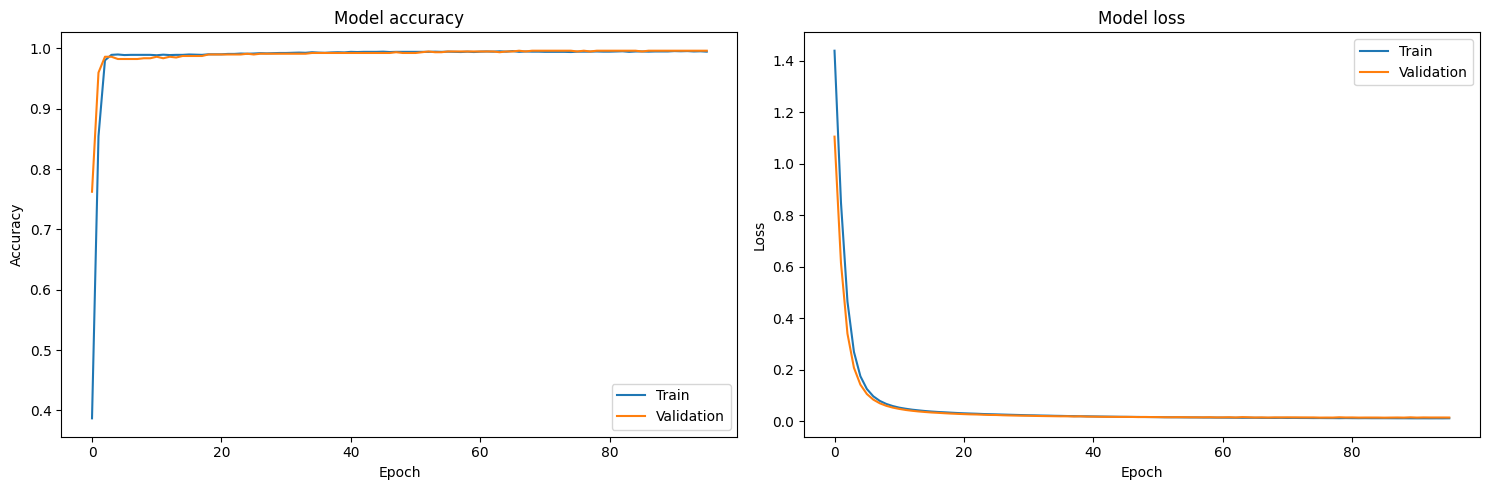

In [ ]:
# Plot history pelatihan
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

**Menyimpan Model & Uji Coba Prediksi**

In [ ]:
# Import libraries yang diperlukan
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib

In [ ]:
# Menyimpan model
model_name = "model_obat5"
save_dir = "/content/"
model_path = os.path.join(save_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/model_obat5b.h5


<ipython-input-17-c8d776d052f4>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


In [ ]:
# Menyimpan scaler
scaler_filename = "/content/scaler_obat5.save"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

Scaler saved to /content/scaler_obat5b.save


In [ ]:
# Memuat model yang telah disimpan
loaded_model = load_model('/content/model_obat5.h5')

# Memuat scaler
scaler_filename = "/content/scaler_obat5.save"
scaler = joblib.load(scaler_filename)

In [ ]:
# Data spektrum yang akan diuji (pastikan jumlah fitur cocok dengan model)
sample_spectrum = np.array([[0.000375909963270948, 0.577818708380709, 0.534319805520911, 0.142955510870815, 0.717543945121563, 0.038442050027585]])

# Standarisasi sample_spectrum menggunakan scaler yang dimuat
sample_spectrum_scaled = scaler.transform(sample_spectrum)

# Nama-nama polutan yang ingin diprediksi
pollutant_names = ['Rifampisin', 'Digoxin', 'CTM', 'Simvastatin', 'Diclofenac Sodium']

# Melakukan prediksi dengan model yang telah dimuat
prediction = loaded_model.predict(sample_spectrum_scaled)
predicted_class = np.argmax(prediction[0])
confidence = prediction[0][predicted_class]

1/1 [==============================] - 0s 76ms/step


In [ ]:
# Menampilkan hasil prediksi
print("Prediction Result:")
print(f"Detected Pollutant: {pollutant_names[predicted_class]}")
print(f"Confidence: {confidence:.2f}")

Prediction Result:
Detected Pollutant: Simvastatin
Confidence: 1.00


In [ ]:
# Menampilkan probabilitas untuk semua kelas
print("Probabilities for all classes:")
for name, prob in zip(pollutant_names, prediction[0]):
    print(f"{name}: {prob:.4f}")

Probabilities for all classes:
Rifampisin: 0.0000
Digoxin: 0.0002
CTM: 0.0000
Simvastatin: 0.9998
Diclofenac Sodium: 0.0000
